# Random Forest: Bagging + Feature Randomness

**Core Concept:** Random Forest extends Bagging by adding another layer of randomness - random feature selection at each split.

**Key Difference from Bagging:**
- **Bagging:** All features available at each split
- **Random Forest:** Only random subset of features available at each split

**Why this matters:** Further decorrelates trees, leading to even better variance reduction.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, IntSlider, Dropdown, FloatSlider
from sklearn.datasets import load_iris, make_classification, load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd

# Import custom library
import sys
import os
sys.path.append(os.getcwd())

try:
    from MyML import MyDecisionTreeClassifier, GeneralBaggingClassifier
    from MyML import MyRandomForestClassifier  
    print("Success: MyML Custom Library Loaded!")
except ImportError as e:
    print(f"Warning: MyRandomForestClassifier not found. Will use sklearn for demo.")
    from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
    from sklearn.tree import DecisionTreeClassifier

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 100

# Set random seed
np.random.seed(42)

## Part 1: Load Multi-Feature Dataset

We'll use the Wine dataset which has 13 features - perfect for demonstrating feature randomness.

WINE DATASET INFORMATION:
Total samples: 178
Training samples: 124
Test samples: 54
Number of features: 13
Number of classes: 3

Feature names:
  1. alcohol
  2. malic_acid
  3. ash
  4. alcalinity_of_ash
  5. magnesium
  6. total_phenols
  7. flavanoids
  8. nonflavanoid_phenols
  9. proanthocyanins
  10. color_intensity
  11. hue
  12. od280/od315_of_diluted_wines
  13. proline


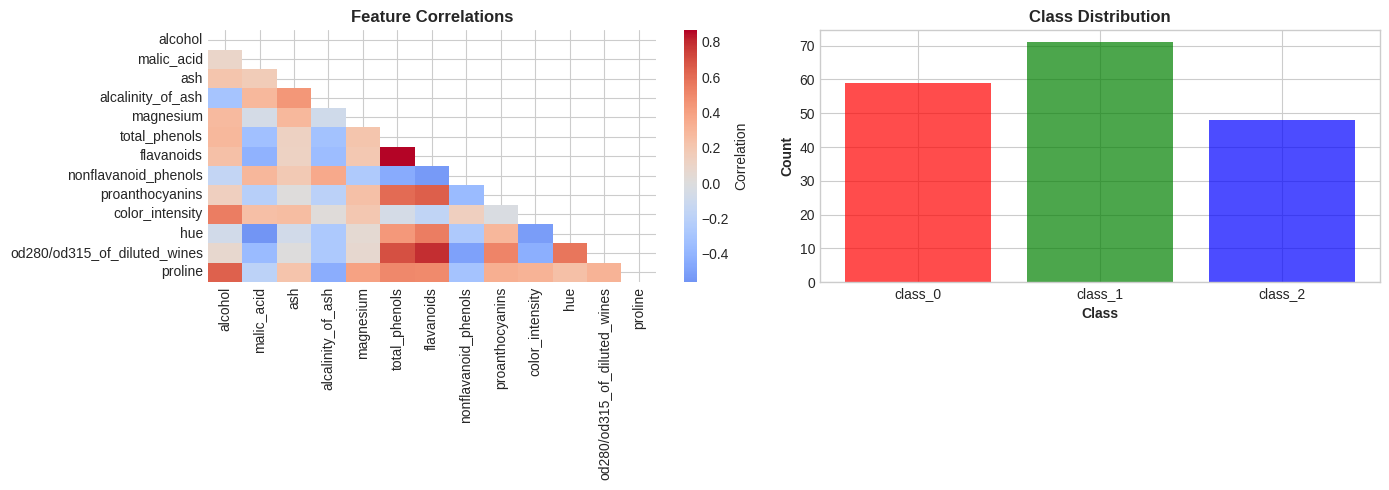


NOTE: Some features are highly correlated.
Random Forest's feature randomness helps handle this!


In [2]:
# Load Wine dataset (13 features, 3 classes)
wine = load_wine()
X = wine.data
y = wine.target
feature_names = wine.feature_names

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("WINE DATASET INFORMATION:")
print("="*60)
print(f"Total samples: {len(X)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"\nFeature names:")
for i, name in enumerate(feature_names):
    print(f"  {i+1}. {name}")

# Visualize feature correlations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlation heatmap
df = pd.DataFrame(X, columns=feature_names)
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=False, cmap='coolwarm', center=0,
            cbar_kws={'label': 'Correlation'}, ax=axes[0])
axes[0].set_title('Feature Correlations', fontweight='bold', fontsize=12)

# Class distribution
unique, counts = np.unique(y, return_counts=True)
axes[1].bar(unique, counts, color=['red', 'green', 'blue'], alpha=0.7)
axes[1].set_xlabel('Class', fontweight='bold')
axes[1].set_ylabel('Count', fontweight='bold')
axes[1].set_title('Class Distribution', fontweight='bold', fontsize=12)
axes[1].set_xticks(unique)
axes[1].set_xticklabels([wine.target_names[i] for i in unique])

plt.tight_layout()
plt.show()

print("\nNOTE: Some features are highly correlated.")
print("Random Forest's feature randomness helps handle this!")

## Part 2: Bagging vs Random Forest Comparison

Let's compare performance with different levels of feature randomness.

Training models with different feature selection strategies...

1. Single Decision Tree...
   Accuracy: 0.9630

2. Bagging (all features)...
   Accuracy: 1.0000

3.1. Random Forest (max_features=sqrt, 3 features)...
   Accuracy: 1.0000

3.2. Random Forest (max_features=log2, 3 features)...
   Accuracy: 1.0000

3.3. Random Forest (max_features=1/3, 4 features)...
   Accuracy: 1.0000


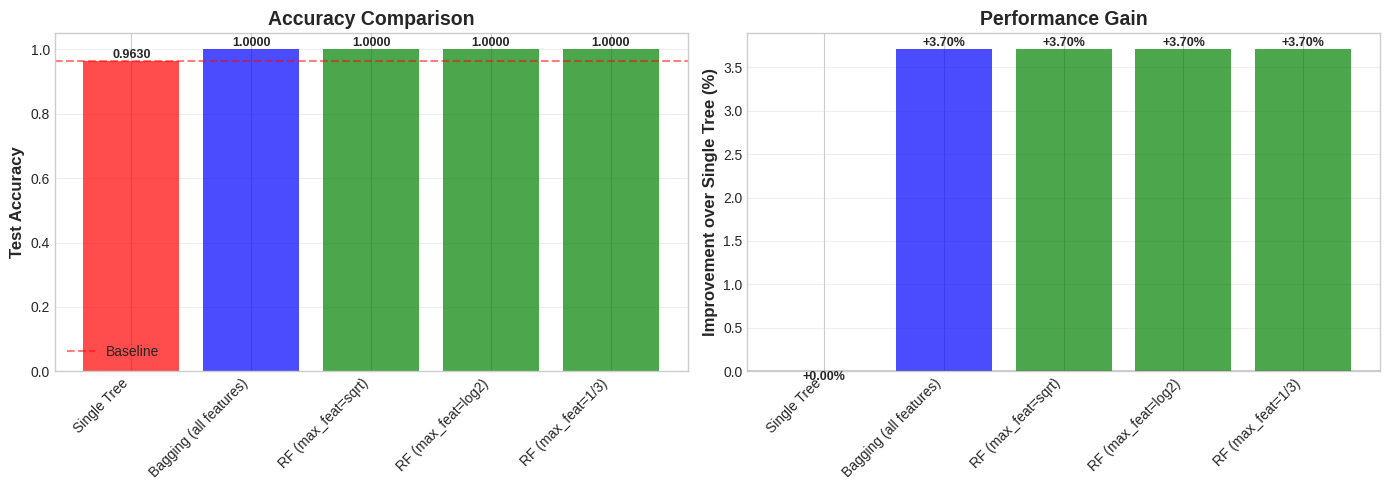


SUMMARY:
Best model: Bagging (all features)
Best accuracy: 1.0000
Improvement over single tree: +3.70%


In [3]:
# Train models with different max_features
n_features = X.shape[1]
n_estimators = 100

results = {}

print("Training models with different feature selection strategies...\n")

# 1. Single Tree (baseline)
print("1. Single Decision Tree...")
single_tree = DecisionTreeClassifier(max_depth=10, random_state=42)
single_tree.fit(X_train, y_train)
results['Single Tree'] = accuracy_score(y_test, single_tree.predict(X_test))
print(f"   Accuracy: {results['Single Tree']:.4f}")

# 2. Bagging (all features)
print("\n2. Bagging (all features)...")
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=10),
    n_estimators=n_estimators,
    random_state=42
)
bagging.fit(X_train, y_train)
results['Bagging (all features)'] = accuracy_score(y_test, bagging.predict(X_test))
print(f"   Accuracy: {results['Bagging (all features)']:.4f}")

# 3. Random Forest with different max_features
max_features_options = [
    ('sqrt', int(np.sqrt(n_features))),
    ('log2', int(np.log2(n_features))),
    ('1/3', n_features // 3)
]

for name, max_feat in max_features_options:
    print(f"\n3.{len(results)-1}. Random Forest (max_features={name}, {max_feat} features)...")
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_features=max_feat,
        max_depth=10,
        random_state=42
    )
    rf.fit(X_train, y_train)
    results[f'RF (max_feat={name})'] = accuracy_score(y_test, rf.predict(X_test))
    print(f"   Accuracy: {results[f'RF (max_feat={name})']:.4f}")

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
names = list(results.keys())
accs = list(results.values())
colors = ['red'] + ['blue'] + ['green'] * (len(names) - 2)

bars = axes[0].bar(range(len(names)), accs, color=colors, alpha=0.7)
axes[0].set_xticks(range(len(names)))
axes[0].set_xticklabels(names, rotation=45, ha='right')
axes[0].set_ylabel('Test Accuracy', fontweight='bold', fontsize=12)
axes[0].set_title('Accuracy Comparison', fontweight='bold', fontsize=14)
axes[0].axhline(y=results['Single Tree'], color='red', linestyle='--', 
               alpha=0.5, label='Baseline')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].legend()

# Add value labels
for bar, acc in zip(bars, accs):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.4f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=9)

# Improvement chart
baseline = results['Single Tree']
improvements = [(acc - baseline) * 100 for acc in accs]

bars2 = axes[1].bar(range(len(names)), improvements, color=colors, alpha=0.7)
axes[1].set_xticks(range(len(names)))
axes[1].set_xticklabels(names, rotation=45, ha='right')
axes[1].set_ylabel('Improvement over Single Tree (%)', fontweight='bold', fontsize=12)
axes[1].set_title('Performance Gain', fontweight='bold', fontsize=14)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, imp in zip(bars2, improvements):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{imp:+.2f}%', ha='center', va='bottom' if imp > 0 else 'top',
                fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("SUMMARY:")
print("="*60)
best_model = max(results.items(), key=lambda x: x[1])
print(f"Best model: {best_model[0]}")
print(f"Best accuracy: {best_model[1]:.4f}")
print(f"Improvement over single tree: {(best_model[1] - baseline)*100:+.2f}%")

## Part 3: Feature Importance Analysis

One of Random Forest's key advantages: it provides feature importance scores.

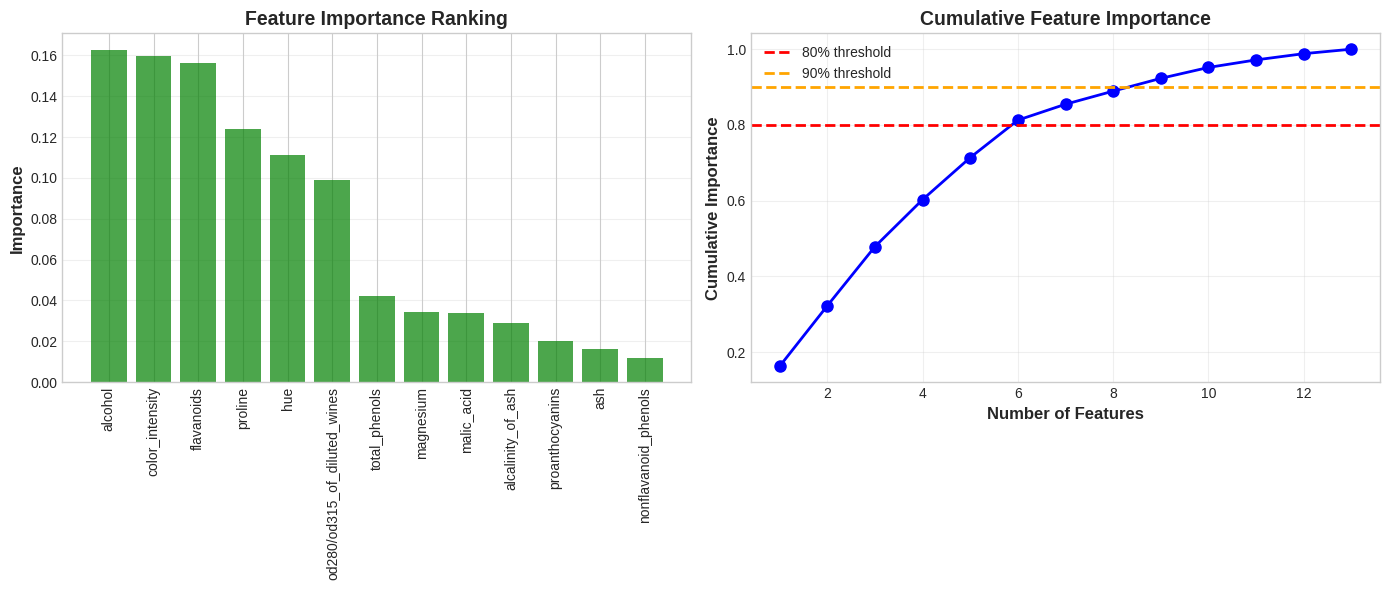


FEATURE IMPORTANCE RANKING:
Rank   Feature                        Importance     
------------------------------------------------------------
1      alcohol                        0.1627
2      color_intensity                0.1597
3      flavanoids                     0.1563
4      proline                        0.1241
5      hue                            0.1110
6      od280/od315_of_diluted_wines   0.0989
7      total_phenols                  0.0420
8      magnesium                      0.0346
9      malic_acid                     0.0337
10     alcalinity_of_ash              0.0288
11     proanthocyanins                0.0200
12     ash                            0.0164
13     nonflavanoid_phenols           0.0118

Features needed for 80% importance: 6/13
Features needed for 90% importance: 9/13

KEY INSIGHT: Not all features are equally important!
Random Forest helps identify which features matter most.


In [4]:
# Train Random Forest for feature importance
rf_final = RandomForestClassifier(
    n_estimators=100,
    max_features='sqrt',
    max_depth=10,
    random_state=42
)
rf_final.fit(X_train, y_train)

# Get feature importances
importances = rf_final.feature_importances_
indices = np.argsort(importances)[::-1]

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart of feature importances
axes[0].bar(range(len(importances)), importances[indices], color='green', alpha=0.7)
axes[0].set_xticks(range(len(importances)))
axes[0].set_xticklabels([feature_names[i] for i in indices], rotation=90)
axes[0].set_ylabel('Importance', fontweight='bold', fontsize=12)
axes[0].set_title('Feature Importance Ranking', fontweight='bold', fontsize=14)
axes[0].grid(True, alpha=0.3, axis='y')

# Cumulative importance
cumulative = np.cumsum(importances[indices])
axes[1].plot(range(1, len(cumulative)+1), cumulative, 'o-', 
            linewidth=2, markersize=8, color='blue')
axes[1].axhline(y=0.8, color='red', linestyle='--', linewidth=2, 
               label='80% threshold')
axes[1].axhline(y=0.9, color='orange', linestyle='--', linewidth=2, 
               label='90% threshold')
axes[1].set_xlabel('Number of Features', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Cumulative Importance', fontweight='bold', fontsize=12)
axes[1].set_title('Cumulative Feature Importance', fontweight='bold', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print top features
print("\nFEATURE IMPORTANCE RANKING:")
print("="*60)
print(f"{'Rank':<6} {'Feature':<30} {'Importance':<15}")
print("-"*60)
for i, idx in enumerate(indices):
    print(f"{i+1:<6} {feature_names[idx]:<30} {importances[idx]:.4f}")

# Find features needed for 80% and 90% importance
n_80 = np.argmax(cumulative >= 0.8) + 1
n_90 = np.argmax(cumulative >= 0.9) + 1

print("\n" + "="*60)
print(f"Features needed for 80% importance: {n_80}/{len(importances)}")
print(f"Features needed for 90% importance: {n_90}/{len(importances)}")
print("\nKEY INSIGHT: Not all features are equally important!")
print("Random Forest helps identify which features matter most.")

## Part 4: Interactive Exploration

Explore how max_features affects performance and tree diversity.

In [ ]:
def explore_max_features(max_features_ratio):
    """
    Explore effect of max_features parameter.
    
    max_features_ratio: Fraction of features to consider (0.1 to 1.0)
    """
    
    max_feat = max(1, int(n_features * max_features_ratio))
    
    # Train Random Forest
    rf = RandomForestClassifier(
        n_estimators=100,
        max_features=max_feat,
        max_depth=10,
        random_state=42
    )
    rf.fit(X_train, y_train)
    
    # Evaluate
    train_acc = accuracy_score(y_train, rf.predict(X_train))
    test_acc = accuracy_score(y_test, rf.predict(X_test))
    
    # Measure tree diversity (how different are the trees?)
    # Sample predictions from different trees
    tree_predictions = []
    for tree in rf.estimators_[:20]:  # Sample 20 trees
        tree_predictions.append(tree.predict(X_test))
    tree_predictions = np.array(tree_predictions)
    
    # Calculate pairwise agreement between trees
    agreements = []
    for i in range(len(tree_predictions)):
        for j in range(i+1, len(tree_predictions)):
            agreement = np.mean(tree_predictions[i] == tree_predictions[j])
            agreements.append(agreement)
    
    avg_agreement = np.mean(agreements)
    diversity = 1 - avg_agreement
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Plot 1: Accuracy comparison
    bars = axes[0].bar(['Training', 'Test'], [train_acc, test_acc], 
                       color=['blue', 'green'], alpha=0.7)
    axes[0].set_ylabel('Accuracy', fontweight='bold', fontsize=12)
    axes[0].set_title(f'Performance\nmax_features = {max_feat}/{n_features}', 
                     fontweight='bold', fontsize=12)
    axes[0].set_ylim([0.8, 1.0])
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, acc in zip(bars, [train_acc, test_acc]):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Tree diversity
    axes[1].bar(['Agreement', 'Diversity'], [avg_agreement, diversity],
               color=['red', 'green'], alpha=0.7)
    axes[1].set_ylabel('Score', fontweight='bold', fontsize=12)
    axes[1].set_title('Tree Diversity\n(Lower agreement = Higher diversity)', 
                     fontweight='bold', fontsize=12)
    axes[1].set_ylim([0, 1])
    axes[1].grid(True, alpha=0.3, axis='y')
    
    for i, (label, val) in enumerate([('Agreement', avg_agreement), ('Diversity', diversity)]):
        axes[1].text(i, val, f'{val:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 3: Feature importance (top 10)
    importances = rf.feature_importances_
    top_indices = np.argsort(importances)[-10:][::-1]
    
    axes[2].barh(range(10), importances[top_indices], color='purple', alpha=0.7)
    axes[2].set_yticks(range(10))
    axes[2].set_yticklabels([feature_names[i] for i in top_indices], fontsize=9)
    axes[2].set_xlabel('Importance', fontweight='bold', fontsize=12)
    axes[2].set_title('Top 10 Important Features', fontweight='bold', fontsize=12)
    axes[2].invert_yaxis()
    axes[2].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    # Print analysis
    gap = train_acc - test_acc
    print(f"\nConfiguration: max_features = {max_feat} ({max_features_ratio:.2%} of {n_features})")
    print(f"Training accuracy: {train_acc:.4f}")
    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Train-test gap: {gap:.4f}")
    print(f"Tree diversity: {diversity:.4f}")
    
    if gap > 0.05:
        print("\nWARNING: High train-test gap suggests overfitting!")
    
    if diversity < 0.1:
        print("WARNING: Low diversity - trees are too similar!")
        print("Try reducing max_features for more diversity.")
    elif diversity > 0.4:
        print("GOOD: High diversity - trees are sufficiently different!")

# Interactive widget
print("ADJUST max_features to see effect on performance and diversity:\n")
interact(explore_max_features,
         max_features_ratio=FloatSlider(
             min=0.1, max=1.0, step=0.1, value=0.3,
             description='Features %:',
             continuous_update=False
         ));

ADJUST max_features to see effect on performance and diversity:



interactive(children=(FloatSlider(value=0.3, continuous_update=False, description='Features %:', max=1.0, min=…

## Part 5: Tree Correlation Analysis

Visualize how feature randomness decorrelates trees.

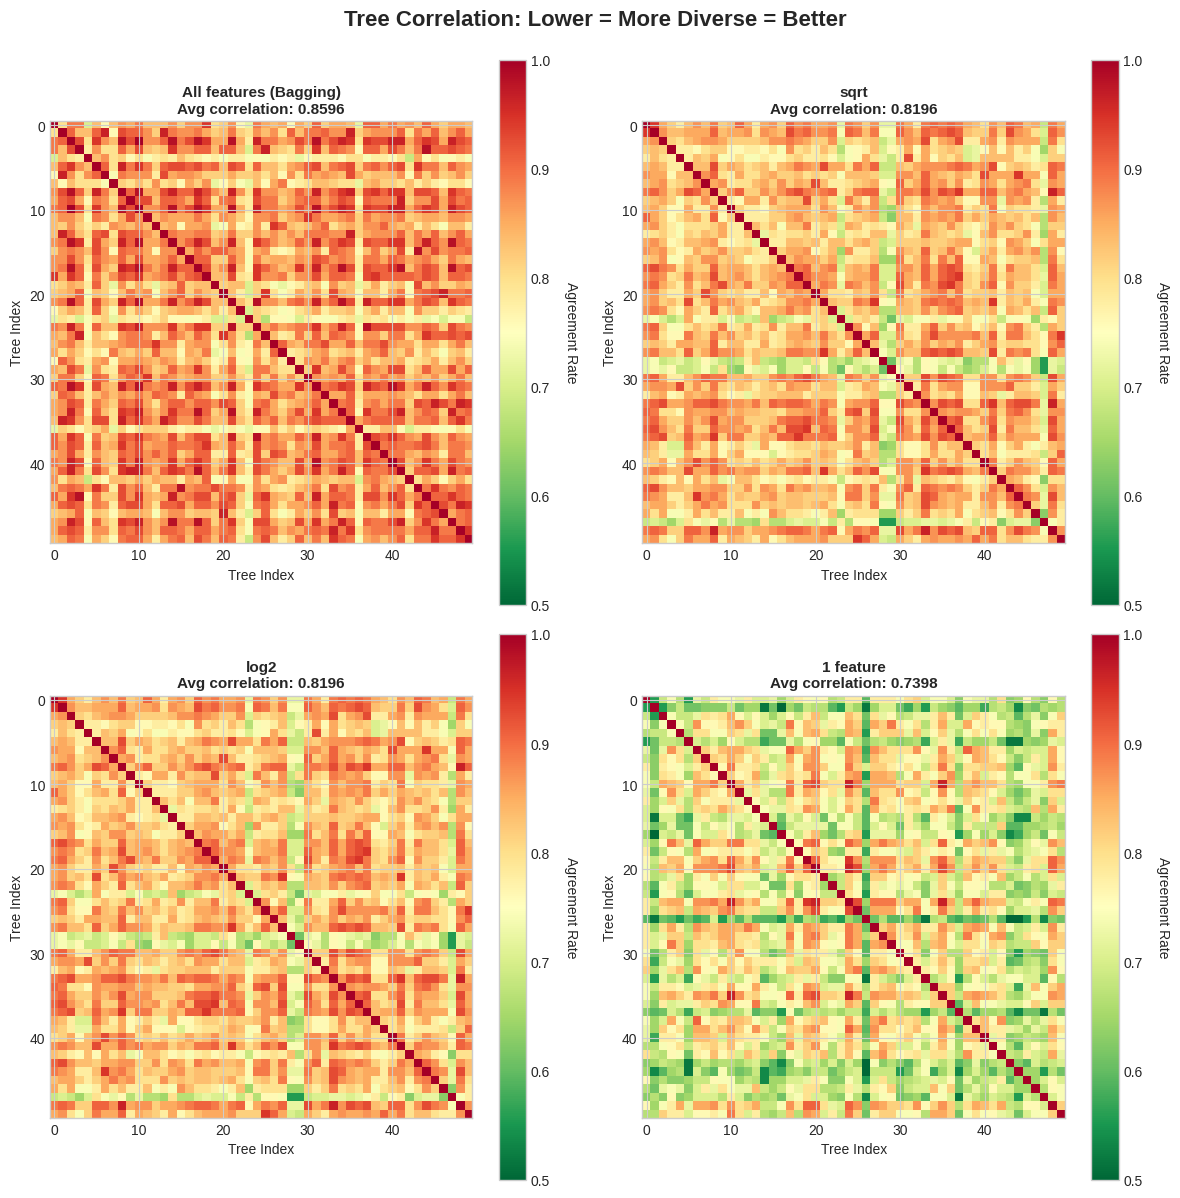


INTERPRETATION:
- Dark red = High correlation (trees make similar predictions)
- Green = Low correlation (trees make diverse predictions)
- Lower max_features -> More diversity -> Better ensemble

KEY INSIGHT: Feature randomness decorrelates trees!


In [6]:
# Train models with different max_features
max_features_configs = {
    'All features (Bagging)': n_features,
    'sqrt': int(np.sqrt(n_features)),
    'log2': int(np.log2(n_features)),
    '1 feature': 1
}

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()

for idx, (name, max_feat) in enumerate(max_features_configs.items()):
    # Train model
    rf = RandomForestClassifier(
        n_estimators=50,
        max_features=max_feat,
        max_depth=10,
        random_state=42
    )
    rf.fit(X_train, y_train)
    
    # Get predictions from all trees
    tree_preds = np.array([tree.predict(X_test) for tree in rf.estimators_])
    
    # Compute correlation matrix
    n_trees = len(rf.estimators_)
    corr_matrix = np.zeros((n_trees, n_trees))
    
    for i in range(n_trees):
        for j in range(n_trees):
            # Correlation = agreement rate
            corr_matrix[i, j] = np.mean(tree_preds[i] == tree_preds[j])
    
    # Plot heatmap
    im = axes[idx].imshow(corr_matrix, cmap='RdYlGn_r', vmin=0.5, vmax=1.0)
    axes[idx].set_title(f'{name}\nAvg correlation: {np.mean(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]):.4f}',
                       fontweight='bold', fontsize=11)
    axes[idx].set_xlabel('Tree Index')
    axes[idx].set_ylabel('Tree Index')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[idx])
    cbar.set_label('Agreement Rate', rotation=270, labelpad=20)

plt.suptitle('Tree Correlation: Lower = More Diverse = Better', 
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\nINTERPRETATION:")
print("="*60)
print("- Dark red = High correlation (trees make similar predictions)")
print("- Green = Low correlation (trees make diverse predictions)")
print("- Lower max_features -> More diversity -> Better ensemble")
print("\nKEY INSIGHT: Feature randomness decorrelates trees!")

## Part 6: Comprehensive Comparison Summary

Training final models for comparison...

Training Single Tree...
  Train: 1.0000, Test: 0.9630, Gap: 0.0370
Training Bagging (50 trees)...
  Train: 1.0000, Test: 1.0000, Gap: 0.0000
Training Random Forest (50 trees)...
  Train: 1.0000, Test: 1.0000, Gap: 0.0000


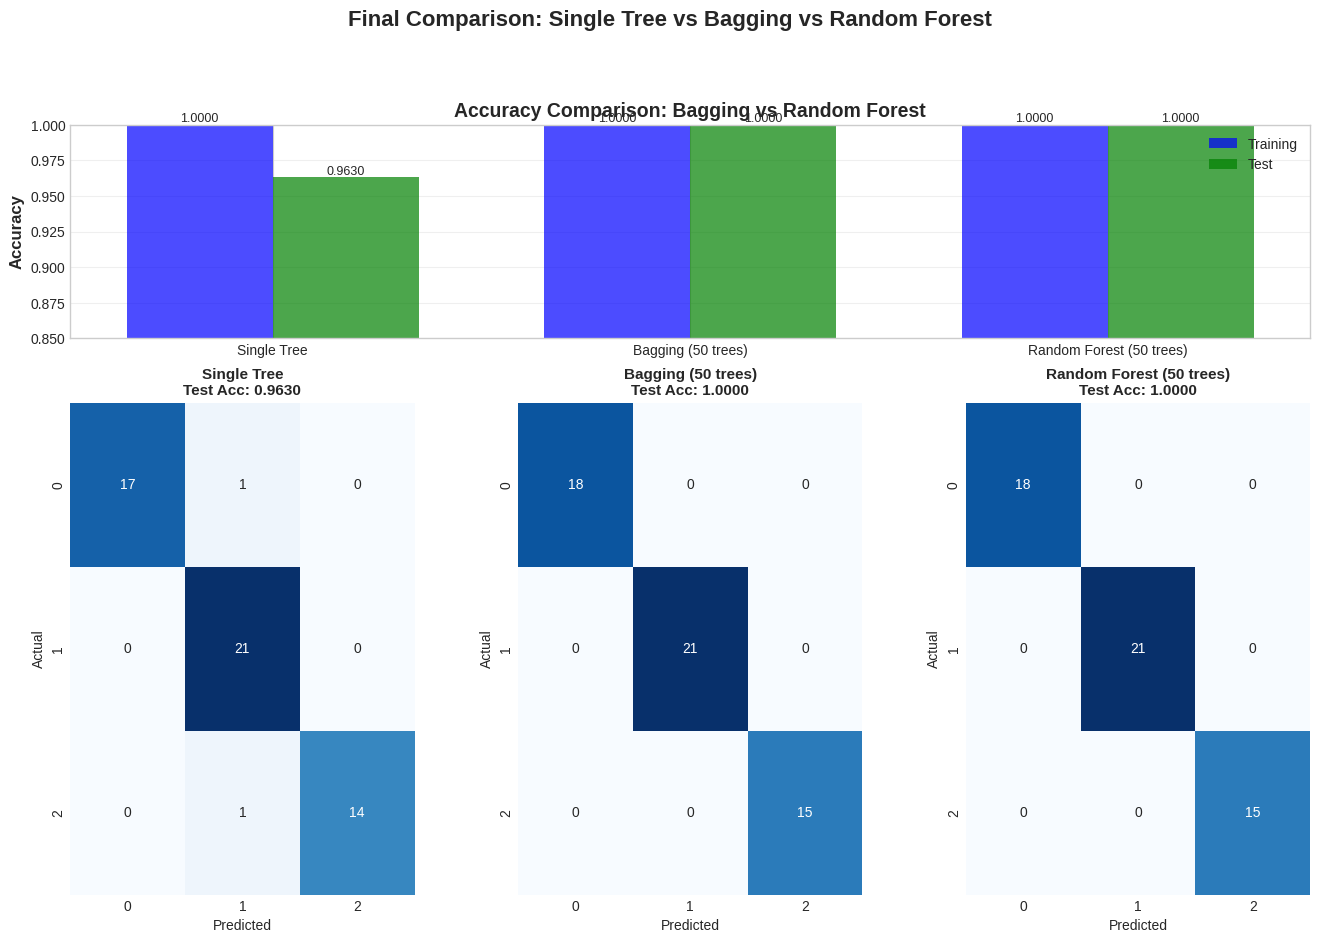


FINAL COMPARISON SUMMARY
Model                          Train Acc    Test Acc     Gap       
----------------------------------------------------------------------
Single Tree                    1.0000       0.9630       0.0370
Bagging (50 trees)             1.0000       1.0000       0.0000
Random Forest (50 trees)       1.0000       1.0000       0.0000

Best model: Bagging (50 trees)
Test accuracy: 1.0000


In [7]:
# Train final models for comprehensive comparison
models_to_compare = {
    'Single Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Bagging (50 trees)': BaggingClassifier(
        estimator=DecisionTreeClassifier(max_depth=10),
        n_estimators=50,
        random_state=42
    ),
    'Random Forest (50 trees)': RandomForestClassifier(
        n_estimators=50,
        max_features='sqrt',
        max_depth=10,
        random_state=42
    )
}

results_final = {}
confusion_matrices = {}

print("Training final models for comparison...\n")

for name, model in models_to_compare.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    
    results_final[name] = {
        'train_acc': train_acc,
        'test_acc': test_acc,
        'gap': train_acc - test_acc
    }
    
    confusion_matrices[name] = confusion_matrix(y_test, model.predict(X_test))
    print(f"  Train: {train_acc:.4f}, Test: {test_acc:.4f}, Gap: {train_acc - test_acc:.4f}")

# Visualize comprehensive comparison
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Accuracy comparison
ax1 = fig.add_subplot(gs[0, :])
model_names = list(results_final.keys())
train_accs = [results_final[name]['train_acc'] for name in model_names]
test_accs = [results_final[name]['test_acc'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax1.bar(x - width/2, train_accs, width, label='Training', color='blue', alpha=0.7)
bars2 = ax1.bar(x + width/2, test_accs, width, label='Test', color='green', alpha=0.7)

ax1.set_ylabel('Accuracy', fontweight='bold', fontsize=12)
ax1.set_title('Accuracy Comparison: Bagging vs Random Forest', fontweight='bold', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(model_names)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0.85, 1.0])

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Plot 2-4: Confusion matrices
for idx, (name, cm) in enumerate(confusion_matrices.items()):
    ax = fig.add_subplot(gs[1:, idx])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'{name}\nTest Acc: {results_final[name]["test_acc"]:.4f}',
                fontweight='bold', fontsize=11)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.suptitle('Final Comparison: Single Tree vs Bagging vs Random Forest',
            fontsize=16, fontweight='bold', y=0.995)
plt.show()

# Print summary table
print("\n" + "="*70)
print("FINAL COMPARISON SUMMARY")
print("="*70)
print(f"{'Model':<30} {'Train Acc':<12} {'Test Acc':<12} {'Gap':<10}")
print("-"*70)
for name in model_names:
    r = results_final[name]
    print(f"{name:<30} {r['train_acc']:.4f}       {r['test_acc']:.4f}       {r['gap']:.4f}")
print("="*70)

# Best model
best_model = max(results_final.items(), key=lambda x: x[1]['test_acc'])[0]
print(f"\nBest model: {best_model}")
print(f"Test accuracy: {results_final[best_model]['test_acc']:.4f}")

## Summary

1. **Random Forest = Bagging + Feature Randomness**
   - Bagging: Bootstrap samples only
   - Random Forest: Bootstrap samples + random feature selection

2. **Why Feature Randomness Helps:**
   - Decorrelates trees more effectively
   - Prevents dominant features from always being selected
   - Increases ensemble diversity
   - Better variance reduction

3. **Feature Importance:**
   - Random Forest provides interpretability
   - Identifies which features matter most
   - Useful for feature selection
   - Can reduce dimensionality

4. **Hyperparameter: max_features**
   - Controls feature randomness level
   - Common values: sqrt(n), log2(n), n/3
   - Lower values -> More diversity -> Better generalization
   - Too low -> Individual trees too weak


### When to Use Random Forest:

- Default choice for tabular data
- Need feature importance for interpretability
- Have many correlated features
- Want strong baseline with minimal tuning
- Classification or regression tasks

### Advantages over Bagging:

1. Better decorrelation of trees
2. Feature importance scores
3. Usually better performance
4. Built-in feature selection
5. Less prone to overfitting

### Best Practices:

- Start with max_features='sqrt' for classification
- Use max_features=n/3 for regression
- Increase n_estimators until performance plateaus
- Use out-of-bag (OOB) error for validation
- Consider feature importance for dimensionality reduction

### Random Forest is One of the Most Successful ML Algorithms

- Easy to use
- Robust to overfitting
- Handles high-dimensional data
- Works well out-of-the-box
- Industry standard for many applications